In [1]:
pwd

'C:\\Users\\harry\\Documents\\github\\dl_image_segmentation\\training'

ERROR! Session/line number was not unique in database. History logging moved to new session 284


In [1]:
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os
import tensorflow as tf
from keras import backend as K

from util_functions import plot_all_metrics, filter_pred

from models import build_UNet

from tf_example_creation import features_8bit_image, features_image_arrays, parse_encoded_rgb_img_example, parse_8bit_array_example,\
parse_gdal_example_py, parse_gdal_example_tf, parse_higher_example


Using TensorFlow backend.


## Load VHR Mumbai Data

In [2]:
batch_size = 4

def type_transform(feature, target,identifier):
    return tf.cast(feature, tf.float32), tf.cast(target, tf.float32), identifier

transforms = [type_transform]

train_ratio = 0.8

val_ratio  = 0.5 ## this determines what proportion of the non-train data gets used for val. the rest gets used for test
#e.g. if train ratio is 0.8 and val_ratio is 0.5 then proportions will be: train=80%, val=10%, test=10%

_base = '../../../Data/lusaka_tfrecords/'

Here I load up the original airbus mumbai data and split it into train/val/test sets in a 0.8/0.1/0.1 ratio.

In [5]:
tf_folder_rgbarr = os.path.join(_base, 'lusaka_50cm_rgb_2020')
tf_files_rgbarr = glob.glob(os.path.join(tf_folder_rgbarr, '*'))

data = tf.data.TFRecordDataset(filenames=tf_files_rgbarr).map(parse_8bit_array_example, num_parallel_calls=4)

In [6]:
sum(1 for _ in data.batch(1))

3236

In [7]:
n_samples = 3236 ### found from doing sum(1 for _ in data.batch(1))
n_train_samples = int(train_ratio*n_samples)
n_val_samples = int((n_samples - n_train_samples)*val_ratio)
n_test_samples = n_samples - n_train_samples - n_val_samples 


# Apply transforms
for t in transforms:
    data = data.map(t, num_parallel_calls=4)



data = data.map(lambda x,y,z: (x,y))

# Shuffle the data and split into train and validation set
data = data.shuffle(buffer_size=1000, seed = 0)
data_train = data.take(n_train_samples) \
                 .repeat() \
                 .batch(batch_size)
data_val = data.skip(n_train_samples).take(n_val_samples) \
               .repeat() \
               .batch(batch_size)


data_test = data.skip(n_train_samples + n_val_samples) \
               .repeat() \
               .batch(batch_size)

## Train and save normaliser

Train the normaliser on the training data and save it

In [7]:
### pre-train and save the normaliser

from tensorflow.keras.layers.experimental import preprocessing
normalizer = preprocessing.Normalization() 

for_adapting = data.take(n_train_samples).map(lambda x, y: x) ## takes only the images from the training data, avoids the repeat dataset which makes it infinitely large
print("Adapting Normalisation Layer")
normalizer.adapt(for_adapting)
inputs = tf.keras.layers.Input(shape=(None, None, 3)) ### for 3 band RGB Data
outputs = normalizer(inputs)
norm = tf.keras.Model(inputs=inputs, outputs=outputs)
tf.saved_model.save(norm, "./data/models/norm_harry/")

Adapting Normalisation Layer
INFO:tensorflow:Assets written to: ./data/models/norm_harry/assets


## Build model

In [9]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input


normalizer = tf.keras.models.load_model("./data/models/norm_harry/")

input_layer = tf.keras.layers.Input(shape=(None, None, 3)) ### for 3 band RGB Data

output_layer = build_UNet(input_layer, 32, normalizer)

model = Model(input_layer, output_layer)

## Train and save model

You'll want to make changes the loss function below, and increase the number of epochs


In [7]:
def DiceLoss(targets, inputs, smooth=1e-6):
    
    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    intersection = K.sum(K.dot(targets, inputs))
    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return 1 - dice

In [9]:
def DiceBCELoss(targets, inputs, smooth=1e-6):    
       
    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE =  K.binary_crossentropy(targets, inputs)
    intersection = K.sum(K.dot(targets, inputs))    
    dice_loss = 1 - (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    Dice_BCE = BCE + dice_loss
    
    return Dice_BCE

In [17]:
# Ref: salehi17, "Twersky loss function for image segmentation using 3D FCDN"
# -> the score is computed for each class separately and then summed
# alpha=beta=0.5 : dice coefficient
# alpha=beta=1   : tanimoto coefficient (also known as jaccard)
# alpha+beta=1   : produces set of F*-scores
# implemented by E. Moebel, 06/04/18
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

In [10]:
tf.config.experimental_run_functions_eagerly(True)


model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(
                from_logits=True, 
                reduction='auto'), 
              optimizer="adam", 
              metrics=[
                  tf.keras.metrics.AUC(name = "auroc"), 
                  tf.keras.metrics.AUC(curve = "PR", name ="auprc")
              ])
history = model.fit(data_train,
                                steps_per_epoch=n_train_samples//batch_size,
                                validation_data=data_val,
                                validation_steps=n_val_samples//batch_size,
                                epochs=5)

tf.saved_model.save(model, "../data/models/model_harry/")

plot_all_metrics(history.history)


Train for 647 steps, validate for 81 steps
Epoch 1/5
  2/647 [..............................] - ETA: 47:46 - loss: nan - auroc: 0.5714 - auprc: 0.9653  

InvalidArgumentError: predictions must be >= 0
Condition x >= y did not hold.
First 3 elements of x:
[nan nan nan]
First 1 elements of y:
[0.]

## Load a saved model

Start the code from here (after loading the data) if you've already trained a model and saved it

In [7]:
model = tf.keras.models.load_model("../data/models/model_harry/", custom_objects={"auroc": tf.keras.metrics.AUC(name = "auroc"), "auprc": tf.keras.metrics.AUC(curve = "PR", name ="auprc")})

# Predict and visualise

This will produce a bunch of depreciation warnings but should otherwise run just fine.

You can ajust how many tiles you want to run this on.

You could also create a dataset with specific tiles (chosen by ID) and run only on those.

Note that the preds I have here won't be good as the test model I made was only trained for 5 epochs.

In [8]:
from utility.util_functions import pred_visualiser

/home/jovyan/IC_experiments/utility/util_functions.py:898: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks([], [])
/home/jovyan/IC_experiments/utility/util_functions.py:899: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks([], [])
/home/jovyan/IC_experiments/utility/util_functions.py:900: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[2].set_xticks([], [])
/home/jovyan/IC_experiments/utility/util_functions.py:902: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3

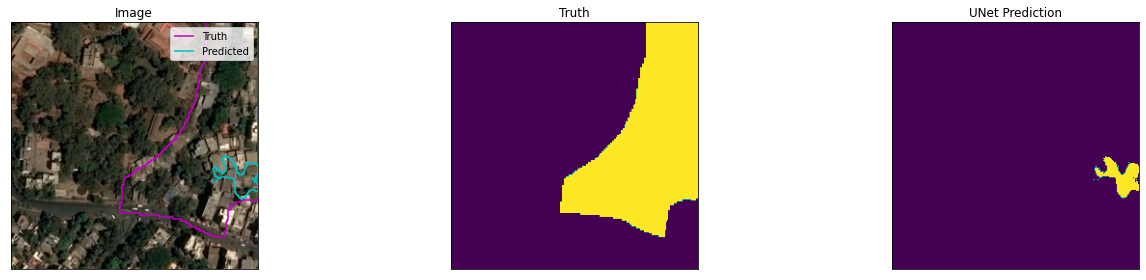

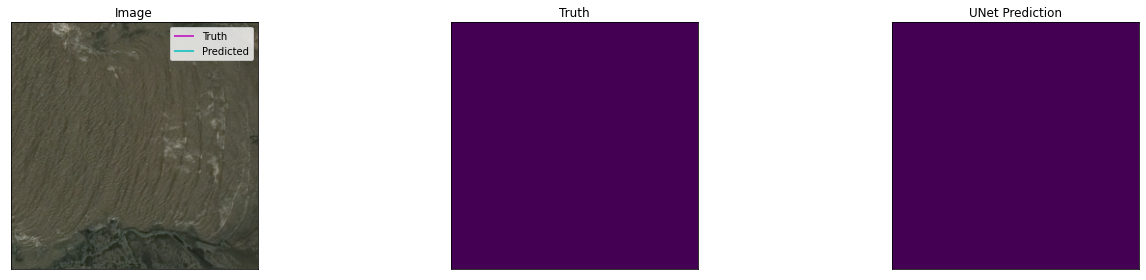

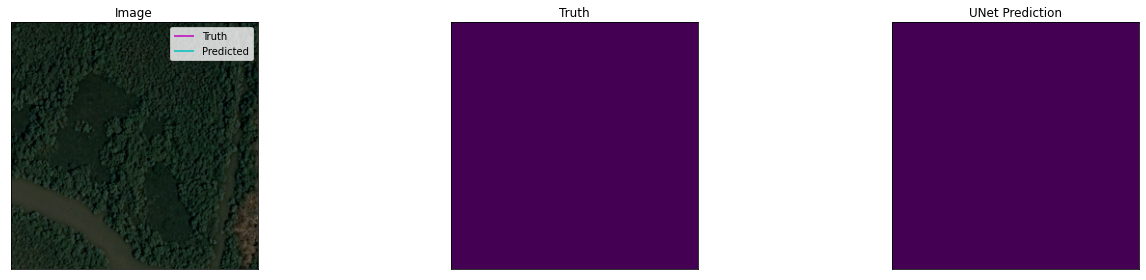

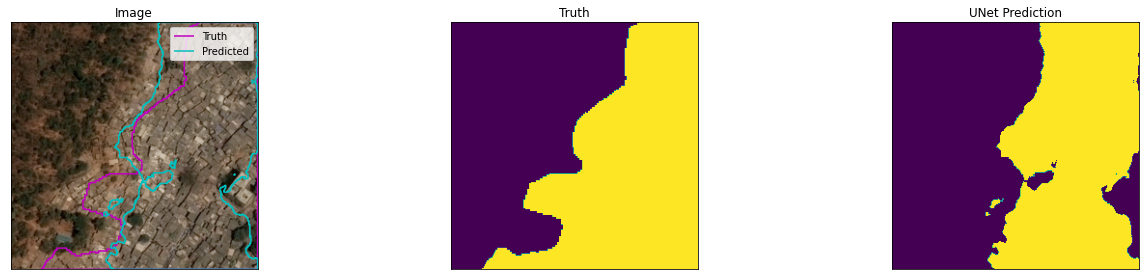

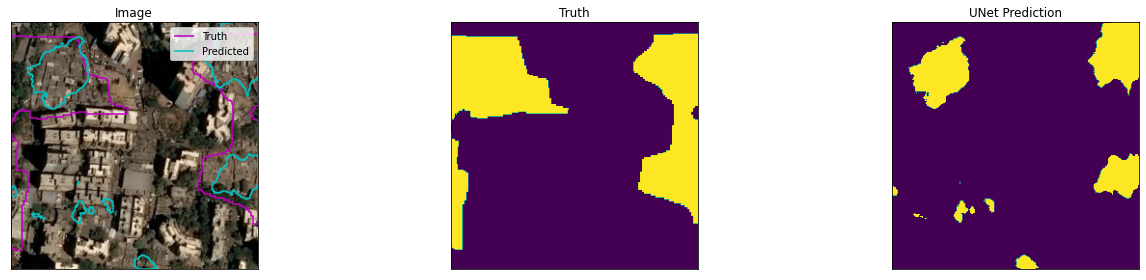

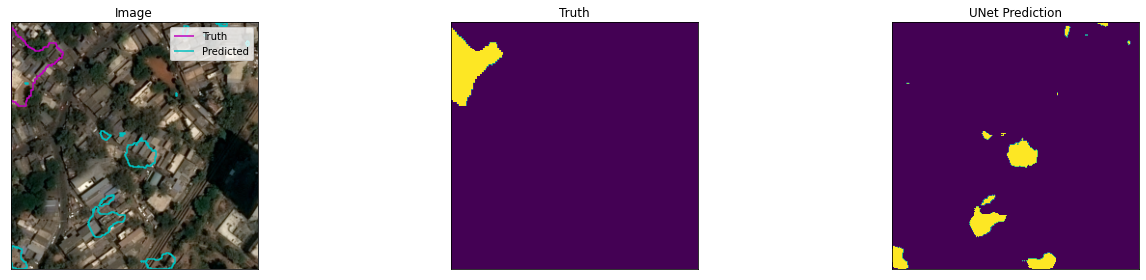

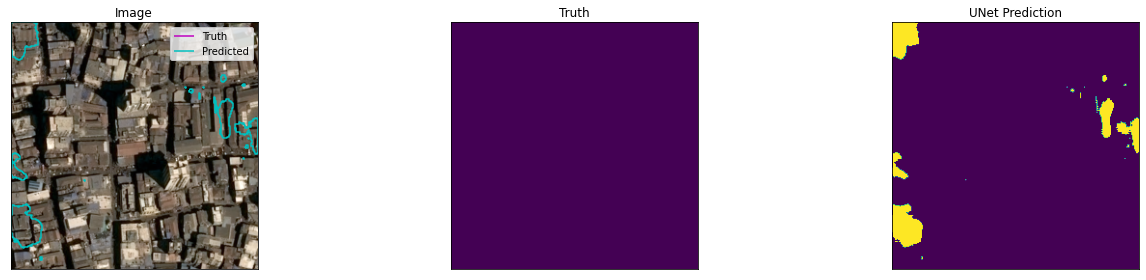

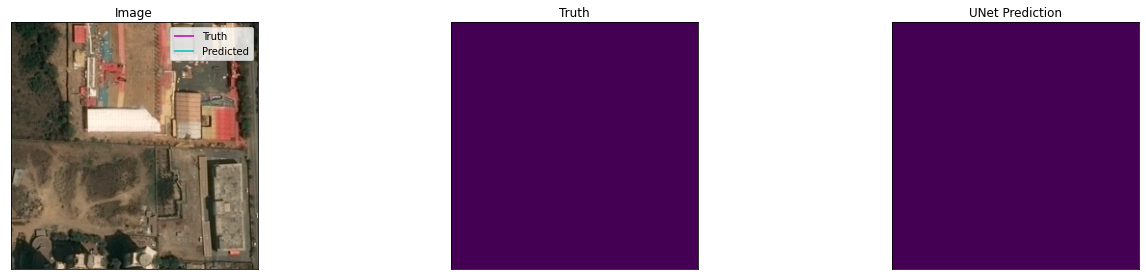

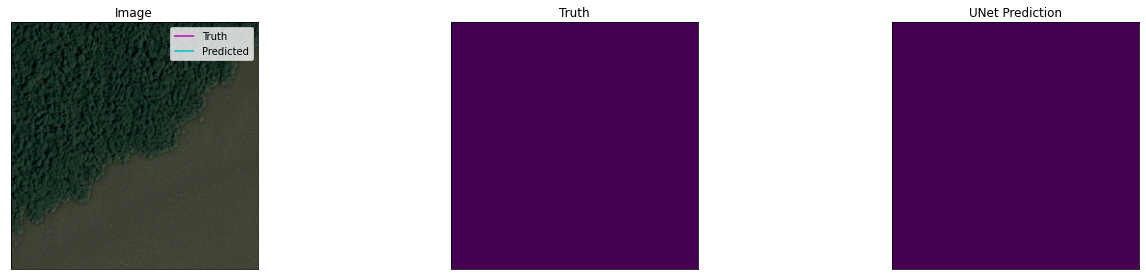

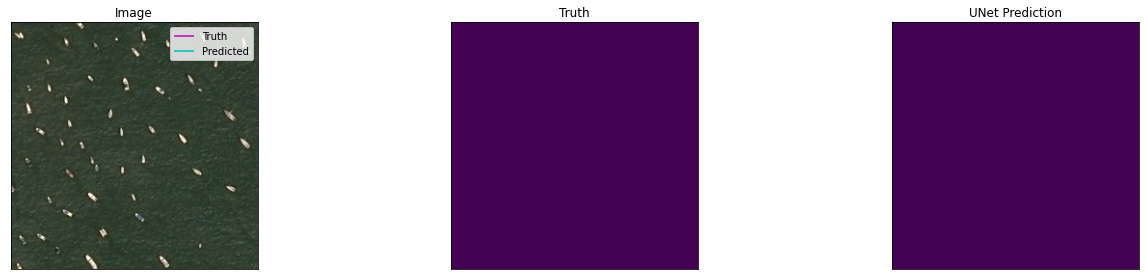

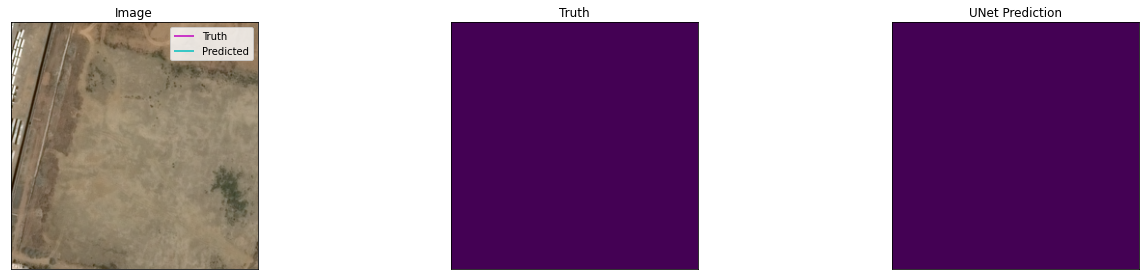

In [9]:
pred_visualiser(dataset = data_test.unbatch().batch(1), num_tiles = 10, model = model)